In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy.stats import normaltest, chi2_contingency, mannwhitneyu, ttest_ind

import warnings
warnings.filterwarnings("ignore")

# **Fleet Optimisation through Fare Forecasting**

## Background

Taxicab bustling around in New York City. Some are driving recklessly, some waits for passenger in the corner for too long, it was a total chaos. A Data Science company is interested in predicting the fare based on variables like pickup location, time of day, and weather. The goal of this analysis is to optimise routes and minimise empty miles by empower the drivers with those foresights.

## Clues

As a data scientist, we would like to have a clue on what do we analyse on this datasets. The clues will be these questions:
- "Can we predict fare spikes near Wall Street Before Market Closing Time?"
- "Does rain affect the amount of rides?"
- "How about time-of-day patterns?"

## Data

To answer the questions, we can look up to the datasets in [here](https://www.kaggle.com/datasets/arashnic/hr-analytics-job-change-of-data-scientists?taskId=3015)

In [37]:
df = pd.read_csv('NYC TLC Trip Record.csv')
df.head(5)

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
0,2,2023-01-01 00:26:10,2023-01-01 00:37:11,N,1.0,166,143,1.0,2.58,14.9,1.0,0.5,4.03,0.0,NaN,1.0,24.18,1.0,1.0,2.75
1,2,2023-01-01 00:51:03,2023-01-01 00:57:49,N,1.0,24,43,1.0,1.81,10.7,1.0,0.5,2.64,0.0,NaN,1.0,15.84,1.0,1.0,0.00
2,2,2023-01-01 00:35:12,2023-01-01 00:41:32,N,1.0,223,179,1.0,0.00,7.2,1.0,0.5,1.94,0.0,NaN,1.0,11.64,1.0,1.0,0.00
3,1,2023-01-01 00:13:14,2023-01-01 00:19:03,N,1.0,41,238,1.0,1.30,6.5,0.5,1.5,1.70,0.0,NaN,1.0,10.20,1.0,1.0,0.00
4,1,2023-01-01 00:33:04,2023-01-01 00:39:02,N,1.0,41,74,1.0,1.10,6.0,0.5,1.5,0.00,0.0,NaN,1.0,8.00,1.0,1.0,0.00


We can see that our data consists of these variables:
- VendorID:ID of vendors
- Lpep Pickup Datetime: Datetime where a passenger is picked up
- Lpep Dropoff Datetime: Datetime where a passenger is dropped off
- Store and Forward Flag: To Flag whether the trip record was held in the vehicle memory before sending it to the vendor. (Yes or No)
- RateCodeID: Final Rate Code, in effect at the end of the trip (1=std; 2=JFK; 3=Newark; 4=Nassau|Westchester; 5=Nego Fare; 6=Group Fare)
- Pickup LocationID: ID of location where a passenger is picked up
- Dropoff LocationID : ID of location where a passenger is dropped off
- Passenger Count: Number of passenger in a trip
- Trip Distance: Distance of a trip
- Fare Amount: Amount of fare
- Extra: Surcharges 0.50$ rush hour or 1$ overnight charges
- MTA Tax: Automatically truggered based on the metered rate in use.
- Tip Amount: Amount of tip
- Tolls Amount: Amount of tolls paid in a trip
- Improvement Surcharge: $0.30 improvement surcharge assessed on hailed trips at the flag drop. The improvement surcharge began being
levied in 2015.
- Total Amount: Amount charged to passengers. Cash Tips excluded
- Payment Type: type of payment (1= Credit Card; 2=cash; 3=No Charge; 4=Dispute; 5 = Unknown; 6=Voided Trip)
- Trip Type: type of taxi trip (1=Street-hail; 2=dispatch)
- Congestion surcharge: Amount added to the payment due to congestion

## Data Understanding

In [38]:
print(f'Number of Columns and Rows of Dataset are {df.shape}')
df.info()

Number of Columns and Rows of Dataset are (68211, 20)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68211 entries, 0 to 68210
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   VendorID               68211 non-null  int64  
 1   lpep_pickup_datetime   68211 non-null  object 
 2   lpep_dropoff_datetime  68211 non-null  object 
 3   store_and_fwd_flag     63887 non-null  object 
 4   RatecodeID             63887 non-null  float64
 5   PULocationID           68211 non-null  int64  
 6   DOLocationID           68211 non-null  int64  
 7   passenger_count        63887 non-null  float64
 8   trip_distance          68211 non-null  float64
 9   fare_amount            68211 non-null  float64
 10  extra                  68211 non-null  float64
 11  mta_tax                68211 non-null  float64
 12  tip_amount             68211 non-null  float64
 13  tolls_amount           68211 non-null  float64
 14  

In [39]:
df.describe()

,VendorID,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
count,68211.000000,63887.000000,68211.000000,68211.000000,63887.000000,68211.000000,68211.000000,68211.000000,68211.000000,68211.000000,68211.000000,0.0,68211.000000,68211.000000,63887.000000,63877.000000,63887.000000
mean,1.863028,1.117160,98.549735,138.429901,1.315870,8.114852,16.603545,0.825431,0.588340,2.139012,0.169627,NaN,0.951625,21.789377,1.373613,1.021933,0.726748
std,0.343820,1.372913,61.244314,76.761311,0.979054,585.105955,13.470121,1.269904,0.385819,3.052710,1.099789,NaN,0.196875,15.457115,0.508039,0.146465,1.212836
min,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,-70.000000,-2.500000,-0.500000,-10.500000,0.000000,NaN,-1.000000,-71.500000,1.000000,1.000000,-2.750000
25%,2.000000,1.000000,74.000000,74.000000,1.000000,1.110000,9.300000,0.000000,0.500000,0.000000,0.000000,NaN,1.000000,12.900000,1.000000,1.000000,0.000000
50%,2.000000,1.000000,75.000000,138.000000,1.000000,1.850000,13.500000,0.000000,0.500000,1.600000,0.000000,NaN,1.000000,17.900000,1.000000,1.000000,0.000000
75%,2.000000,1.000000,129.000000,219.000000,1.000000,3.210000,19.800000,1.000000,0.500000,3.330000,0.000000,NaN,1.000000,26.150000,2.000000,1.000000,2.750000
max,2.000000,99.000000,265.000000,265.000000,9.000000,120098.840000,490.000000,12.500000,2.750000,222.220000,36.050000,NaN,1.000000,491.000000,5.000000,2.000000,2.750000


In [40]:
df.isnull().sum()

VendorID                     0
lpep_pickup_datetime         0
lpep_dropoff_datetime        0
store_and_fwd_flag        4324
RatecodeID                4324
PULocationID                 0
DOLocationID                 0
passenger_count           4324
trip_distance                0
fare_amount                  0
extra                        0
mta_tax                      0
tip_amount                   0
tolls_amount                 0
ehail_fee                68211
improvement_surcharge        0
total_amount                 0
payment_type              4324
trip_type                 4334
congestion_surcharge      4324
dtype: int64

In [3]:
df = df.drop(columns='ehail_fee')

## Data Preprocessing

In [4]:
df.isna().sum()

VendorID                    0
lpep_pickup_datetime        0
lpep_dropoff_datetime       0
store_and_fwd_flag       4324
RatecodeID               4324
PULocationID                0
DOLocationID                0
passenger_count          4324
trip_distance               0
fare_amount                 0
extra                       0
mta_tax                     0
tip_amount                  0
tolls_amount                0
improvement_surcharge       0
total_amount                0
payment_type             4324
trip_type                4334
congestion_surcharge     4324
dtype: int64

### Filling Missing Values with Mean

In [5]:
df['passenger_count'] = df['passenger_count'].fillna(df['passenger_count'].mean()).astype('int')
df['congestion_surcharge'] = df['congestion_surcharge'].fillna(df['congestion_surcharge'].mean())

### Filling Missing Values with Mode

In [6]:
df['store_and_fwd_flag'] = df['store_and_fwd_flag'].fillna(df['store_and_fwd_flag'].mode()[0])
df['RatecodeID'] = df['RatecodeID'].fillna(df['RatecodeID'].mode()[0])
df['trip_type'] = df['trip_type'].fillna(df['trip_type'].mode()[0])

### Filling Missing Values with 'Unknown' for payment_type variable

In [7]:
df['payment_type'] = df['payment_type'].fillna(5)

In [8]:
df.isna().sum()

VendorID                 0
lpep_pickup_datetime     0
lpep_dropoff_datetime    0
store_and_fwd_flag       0
RatecodeID               0
PULocationID             0
DOLocationID             0
passenger_count          0
trip_distance            0
fare_amount              0
extra                    0
mta_tax                  0
tip_amount               0
tolls_amount             0
improvement_surcharge    0
total_amount             0
payment_type             0
trip_type                0
congestion_surcharge     0
dtype: int64

### Renaming Columns to Avoid Future Issues

In [9]:
df = df.rename(columns={'VendorID':'vendor_id'
                       ,'DOLocationID':'do_location_id'
                       ,'RatecodeID':'ratecode_id'
                       ,'PULocationID':'pu_location_id'
                       })

### Joining with Other Dataset to gain Location Name

In [10]:
df_zone = pd.read_csv('taxi_zone_lookup.csv')
df_zone

,LocationID,Borough,Zone,service_zone
0,1,EWR,Newark Airport,EWR
1,2,Queens,Jamaica Bay,Boro Zone
2,3,Bronx,Allerton/Pelham Gardens,Boro Zone
3,4,Manhattan,Alphabet City,Yellow Zone
4,5,Staten Island,Arden Heights,Boro Zone
...,...,...,...,...
260,261,Manhattan,World Trade Center,Yellow Zone
261,262,Manhattan,Yorkville East,Yellow Zone
262,263,Manhattan,Yorkville West,Yellow Zone
263,264,Unknown,NV,NaN


In [11]:
df_combine = df.merge(right=df_zone[['LocationID','Zone']]
                      ,how='left'
                      ,left_on='do_location_id'
                      ,right_on='LocationID')
df_combine = df_combine.drop(columns='LocationID').rename(columns={'Zone':'do_zone'})
df_combine = df_combine.merge(right=df_zone[['LocationID','Zone']]
                      ,how='left'
                      ,left_on='pu_location_id'
                      ,right_on='LocationID')
df_combine = df_combine.drop(columns='LocationID').rename(columns={'Zone':'pu_zone'})
df_combine

,vendor_id,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,ratecode_id,pu_location_id,do_location_id,passenger_count,trip_distance,fare_amount,...,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,do_zone,pu_zone
0,2,2023-01-01 00:26:10,2023-01-01 00:37:11,N,1.0,166,143,1,2.58,14.90,...,0.5,4.03,0.0,1.0,24.18,1.0,1.0,2.750000,Lincoln Square West,Morningside Heights
1,2,2023-01-01 00:51:03,2023-01-01 00:57:49,N,1.0,24,43,1,1.81,10.70,...,0.5,2.64,0.0,1.0,15.84,1.0,1.0,0.000000,Central Park,Bloomingdale
2,2,2023-01-01 00:35:12,2023-01-01 00:41:32,N,1.0,223,179,1,0.00,7.20,...,0.5,1.94,0.0,1.0,11.64,1.0,1.0,0.000000,Old Astoria,Steinway
3,1,2023-01-01 00:13:14,2023-01-01 00:19:03,N,1.0,41,238,1,1.30,6.50,...,1.5,1.70,0.0,1.0,10.20,1.0,1.0,0.000000,Upper West Side North,Central Harlem
4,1,2023-01-01 00:33:04,2023-01-01 00:39:02,N,1.0,41,74,1,1.10,6.00,...,1.5,0.00,0.0,1.0,8.00,1.0,1.0,0.000000,East Harlem North,Central Harlem
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68206,2,2023-01-31 22:29:00,2023-01-31 22:42:00,N,1.0,49,62,1,4070.82,15.70,...,0.0,0.00,0.0,1.0,16.70,5.0,1.0,0.726748,Crown Heights South,Clinton Hill
68207,2,2023-01-31 22:40:00,2023-01-31 22:48:00,N,1.0,10,205,1,2.14,4.41,...,0.0,0.00,0.0,1.0,5.41,5.0,1.0,0.726748,Saint Albans,Baisley Park
68208,2,2023-01-31 23:46:00,2023-02-01 00:02:00,N,1.0,66,37,1,3.44,16.53,...,0.0,3.51,0.0,1.0,21.04,5.0,1.0,0.726748,Bushwick South,DUMBO/Vinegar Hill
68209,2,2023-01-31 23:01:00,2023-01-31 23:19:00,N,1.0,225,189,1,3.03,14.98,...,0.0,3.20,0.0,1.0,19.18,5.0,1.0,0.726748,Prospect Heights,Stuyvesant Heights


In [12]:
valid_ratecodeID = [1, 2, 3, 4, 5, 6]

df_combine = df_combine[df_combine['ratecode_id'].isin(valid_ratecodeID)]
df_combine['trip_type'] = df_combine['trip_type'].map({1:'Street-Hail'
                                                       ,2:'Dispatch'})
df_combine['payment_type'] = df_combine['payment_type'].map({1:'Credit Card'
                                                             ,2:'Cash'
                                                             ,3:'No Charge'
                                                             ,4:'Dispute'
                                                             ,5:'Unknown'
                                                             ,6:'Voided Trip'
                                                             })
df_combine['ratecode_id'] = df_combine['ratecode_id'].map({1:'Standard Rate'
                                                             ,2:'JFK'
                                                             ,3:'Newark'
                                                             ,4:'Nassau or Westchester'
                                                             ,5:'Negotiated Fare'
                                                             ,6:'Group Ride'
                                                             })
df_combine['hour'] = pd.to_datetime(df['lpep_pickup_datetime']).dt.hour
df_combine['day'] = pd.to_datetime(df['lpep_pickup_datetime']).dt.day


df_combine

,vendor_id,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,ratecode_id,pu_location_id,do_location_id,passenger_count,trip_distance,fare_amount,...,tolls_amount,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,do_zone,pu_zone,hour,day
0,2,2023-01-01 00:26:10,2023-01-01 00:37:11,N,Standard Rate,166,143,1,2.58,14.90,...,0.0,1.0,24.18,Credit Card,Street-Hail,2.750000,Lincoln Square West,Morningside Heights,0,1
1,2,2023-01-01 00:51:03,2023-01-01 00:57:49,N,Standard Rate,24,43,1,1.81,10.70,...,0.0,1.0,15.84,Credit Card,Street-Hail,0.000000,Central Park,Bloomingdale,0,1
2,2,2023-01-01 00:35:12,2023-01-01 00:41:32,N,Standard Rate,223,179,1,0.00,7.20,...,0.0,1.0,11.64,Credit Card,Street-Hail,0.000000,Old Astoria,Steinway,0,1
3,1,2023-01-01 00:13:14,2023-01-01 00:19:03,N,Standard Rate,41,238,1,1.30,6.50,...,0.0,1.0,10.20,Credit Card,Street-Hail,0.000000,Upper West Side North,Central Harlem,0,1
4,1,2023-01-01 00:33:04,2023-01-01 00:39:02,N,Standard Rate,41,74,1,1.10,6.00,...,0.0,1.0,8.00,Credit Card,Street-Hail,0.000000,East Harlem North,Central Harlem,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68206,2,2023-01-31 22:29:00,2023-01-31 22:42:00,N,Standard Rate,49,62,1,4070.82,15.70,...,0.0,1.0,16.70,Unknown,Street-Hail,0.726748,Crown Heights South,Clinton Hill,22,31
68207,2,2023-01-31 22:40:00,2023-01-31 22:48:00,N,Standard Rate,10,205,1,2.14,4.41,...,0.0,1.0,5.41,Unknown,Street-Hail,0.726748,Saint Albans,Baisley Park,22,31
68208,2,2023-01-31 23:46:00,2023-02-01 00:02:00,N,Standard Rate,66,37,1,3.44,16.53,...,0.0,1.0,21.04,Unknown,Street-Hail,0.726748,Bushwick South,DUMBO/Vinegar Hill,23,31
68209,2,2023-01-31 23:01:00,2023-01-31 23:19:00,N,Standard Rate,225,189,1,3.03,14.98,...,0.0,1.0,19.18,Unknown,Street-Hail,0.726748,Prospect Heights,Stuyvesant Heights,23,31


In [13]:
df_combine.to_csv('[CLEANED] NYC TLC Trip.csv')

Preview Data

In [14]:
df_combine

,vendor_id,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,ratecode_id,pu_location_id,do_location_id,passenger_count,trip_distance,fare_amount,...,tolls_amount,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,do_zone,pu_zone,hour,day
0,2,2023-01-01 00:26:10,2023-01-01 00:37:11,N,Standard Rate,166,143,1,2.58,14.90,...,0.0,1.0,24.18,Credit Card,Street-Hail,2.750000,Lincoln Square West,Morningside Heights,0,1
1,2,2023-01-01 00:51:03,2023-01-01 00:57:49,N,Standard Rate,24,43,1,1.81,10.70,...,0.0,1.0,15.84,Credit Card,Street-Hail,0.000000,Central Park,Bloomingdale,0,1
2,2,2023-01-01 00:35:12,2023-01-01 00:41:32,N,Standard Rate,223,179,1,0.00,7.20,...,0.0,1.0,11.64,Credit Card,Street-Hail,0.000000,Old Astoria,Steinway,0,1
3,1,2023-01-01 00:13:14,2023-01-01 00:19:03,N,Standard Rate,41,238,1,1.30,6.50,...,0.0,1.0,10.20,Credit Card,Street-Hail,0.000000,Upper West Side North,Central Harlem,0,1
4,1,2023-01-01 00:33:04,2023-01-01 00:39:02,N,Standard Rate,41,74,1,1.10,6.00,...,0.0,1.0,8.00,Credit Card,Street-Hail,0.000000,East Harlem North,Central Harlem,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68206,2,2023-01-31 22:29:00,2023-01-31 22:42:00,N,Standard Rate,49,62,1,4070.82,15.70,...,0.0,1.0,16.70,Unknown,Street-Hail,0.726748,Crown Heights South,Clinton Hill,22,31
68207,2,2023-01-31 22:40:00,2023-01-31 22:48:00,N,Standard Rate,10,205,1,2.14,4.41,...,0.0,1.0,5.41,Unknown,Street-Hail,0.726748,Saint Albans,Baisley Park,22,31
68208,2,2023-01-31 23:46:00,2023-02-01 00:02:00,N,Standard Rate,66,37,1,3.44,16.53,...,0.0,1.0,21.04,Unknown,Street-Hail,0.726748,Bushwick South,DUMBO/Vinegar Hill,23,31
68209,2,2023-01-31 23:01:00,2023-01-31 23:19:00,N,Standard Rate,225,189,1,3.03,14.98,...,0.0,1.0,19.18,Unknown,Street-Hail,0.726748,Prospect Heights,Stuyvesant Heights,23,31


## 1. Time of Day Patterns

In [15]:
trx_hrly = df_combine.groupby(by='hour').count()['day'].reset_index().rename(columns={'day':'hrly_trx_amt'})
trx_hrly

,hour,hrly_trx_amt
0,0,1129
1,1,890
2,2,659
3,3,598
4,4,451
5,5,431
6,6,998
7,7,2646
8,8,3219
9,9,3520


Text(0, 0.5, 'taxi pick-ups')

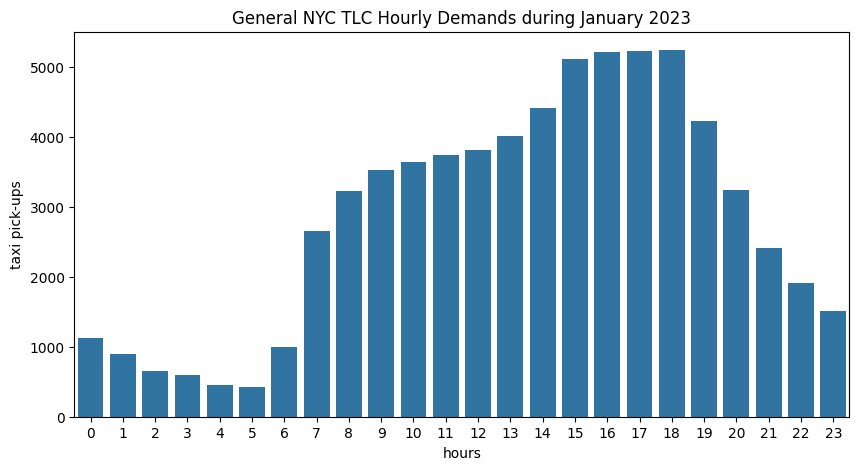

In [16]:
plt.figure(figsize=(10,5))
sns.barplot(errorbar=None, x=trx_hrly['hour'], y=trx_hrly['hrly_trx_amt'])
plt.title('General NYC TLC Hourly Demands during January 2023')
plt.xlabel('hours')
plt.ylabel('taxi pick-ups')

In [17]:
trx_daily = df_combine.groupby(by='day').count()[['hour']].reset_index().rename(columns={'hour':'daily_trx_amt'})
trx_daily = trx_daily.sort_values(by='daily_trx_amt').reset_index()
trx_daily = trx_daily.drop(columns='index')
trx_daily

,day,daily_trx_amt
0,1,1464
1,2,1563
2,16,1584
3,8,1658
4,29,1675
5,22,1774
6,15,1774
7,28,2057
8,3,2125
9,21,2139


Text(0, 0.5, 'taxi pick-ups')

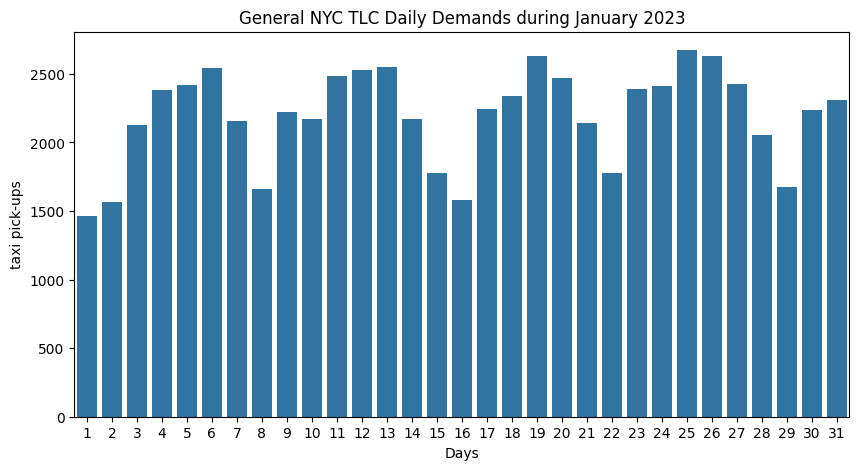

In [18]:
plt.figure(figsize=(10,5))
sns.barplot(errorbar=None, x=trx_daily['day'], y=trx_daily['daily_trx_amt'])
plt.title('General NYC TLC Daily Demands during January 2023')
plt.xlabel('Days')
plt.ylabel('taxi pick-ups')

## 2. Payment Type Distribution

In [19]:
payments = df_combine.groupby(by='payment_type').count()[['vendor_id']].reset_index().rename(columns={'vendor_id':'trx_amt'})
payments

,payment_type,trx_amt
0,Cash,22632
1,Credit Card,40676
2,Dispute,95
3,No Charge,472
4,Unknown,4326


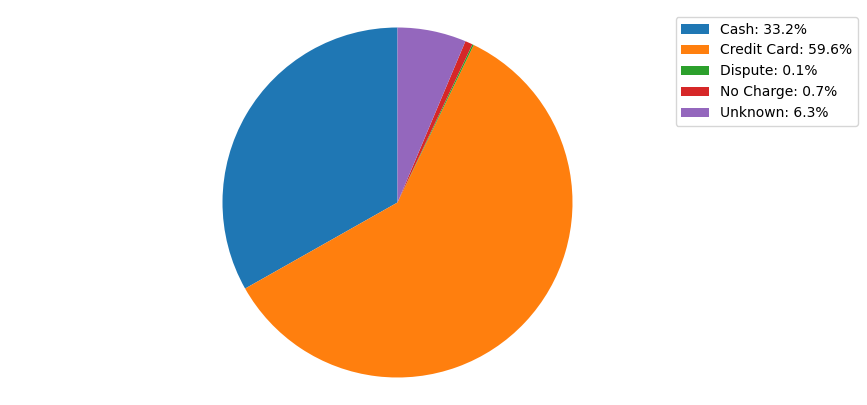

In [20]:
plt.figure(figsize=(10,5))
labels = payments['payment_type']
sizes = payments['trx_amt']
pie = plt.pie(sizes, startangle=90)
plt.axis('equal')
labels = [f'{l}: {(s/sum(sizes)*100) :0.1f}%' for l, s in zip(labels, sizes)]
plt.legend(bbox_to_anchor=(0.85, 1), loc='upper left', labels=labels)
plt.show()

## 3. RatecodeID Distribution

In [21]:
ratecode = df_combine.groupby(by='ratecode_id').count()[['vendor_id']].reset_index().rename(columns={'vendor_id':'trx_amt'})
ratecode

,ratecode_id,trx_amt
0,JFK,158
1,Nassau or Westchester,57
2,Negotiated Fare,1529
3,Newark,30
4,Standard Rate,66427


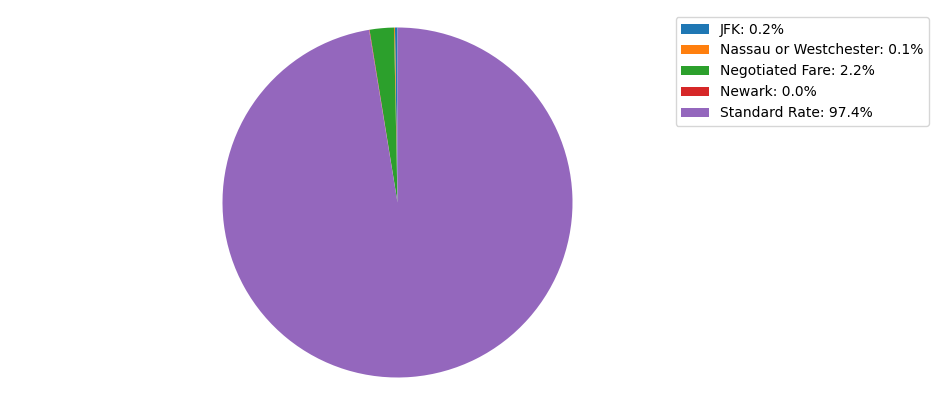

In [22]:
plt.figure(figsize=(10,5))
labels = ratecode['ratecode_id']
sizes = ratecode['trx_amt']
pie = plt.pie(sizes, startangle=90)
plt.axis('equal')
labels = [f'{l}: {(s/sum(sizes)*100) :0.1f}%' for l, s in zip(labels, sizes)]
plt.legend(bbox_to_anchor=(0.85, 1), loc='upper left', labels=labels)
plt.show()

## 4. CM vs Verifone

### Greenest Pickup Place

In [23]:
df_combine['revenue'] = df_combine['total_amount'] + df_combine['tip_amount'] - df_combine['tolls_amount']
df_combine['revenue']

0        28.21
1        18.48
2        13.58
3        11.90
4         8.00
         ...  
68206    16.70
68207     5.41
68208    24.55
68209    22.38
68210    31.40
Name: revenue, Length: 68201, dtype: float64

In [24]:
green_pickup = df_combine[['vendor_id', 'pu_zone', 'revenue']].groupby(by=['pu_zone', 'vendor_id'])['revenue'].sum().sort_values(ascending=False)
green_pickup = pd.DataFrame(green_pickup).reset_index()
green_pickup

,pu_zone,vendor_id,revenue
0,East Harlem North,2,234401.53
1,East Harlem South,2,176781.67
2,Morningside Heights,2,84035.24
3,Forest Hills,2,76948.85
4,Central Harlem,2,72830.33
...,...,...,...
400,Rockaway Park,2,18.87
401,West Brighton,2,18.00
402,Saint Michaels Cemetery/Woodside,1,13.50
403,Breezy Point/Fort Tilden/Riis Beach,2,8.70


In [25]:
green_pickup_CM = green_pickup[green_pickup['vendor_id']==1]
green_pickup_CM

,pu_zone,vendor_id,revenue
7,East Harlem North,1,49651.18
16,East Harlem South,1,24807.36
22,Washington Heights South,1,12535.01
27,Downtown Brooklyn/MetroTech,1,10135.84
31,Morningside Heights,1,9170.17
...,...,...,...
395,Greenwich Village North,1,21.70
396,Crotona Park,1,20.00
397,Jamaica Estates,1,20.00
398,Garment District,1,19.70


In [26]:
green_pickup_V = green_pickup[green_pickup['vendor_id']==2]
green_pickup_V

,pu_zone,vendor_id,revenue
0,East Harlem North,2,234401.53
1,East Harlem South,2,176781.67
2,Morningside Heights,2,84035.24
3,Forest Hills,2,76948.85
4,Central Harlem,2,72830.33
...,...,...,...
399,Stapleton,2,19.32
400,Rockaway Park,2,18.87
401,West Brighton,2,18.00
403,Breezy Point/Fort Tilden/Riis Beach,2,8.70


### Hottest Pickup

In [27]:
hot_pickup = df_combine[['vendor_id', 'pu_zone', 'revenue']].groupby(by=['pu_zone', 'vendor_id'])['revenue'].count().sort_values(ascending=False)
hot_pickup = pd.DataFrame(hot_pickup).reset_index()
hot_pickup = hot_pickup.rename(columns={'revenue':'num_trx'})
hot_pickup

,pu_zone,vendor_id,num_trx
0,East Harlem North,2,10823
1,East Harlem South,2,7922
2,Forest Hills,2,3750
3,Central Harlem,2,3645
4,Morningside Heights,2,3454
...,...,...,...
400,Financial District North,1,1
401,Penn Station/Madison Sq West,2,1
402,Garment District,1,1
403,Stapleton,2,1


In [28]:
hot_pickup_CM = hot_pickup[hot_pickup['vendor_id']==1]
hot_pickup_CM

,pu_zone,vendor_id,num_trx
7,East Harlem North,1,2434
15,East Harlem South,1,1187
25,Downtown Brooklyn/MetroTech,1,431
27,Morningside Heights,1,425
29,Central Harlem,1,413
...,...,...,...
398,East Village,1,1
399,Far Rockaway,1,1
400,Financial District North,1,1
402,Garment District,1,1


In [29]:
hot_pickup_V = hot_pickup[hot_pickup['vendor_id']==2]
hot_pickup_V

,pu_zone,vendor_id,num_trx
0,East Harlem North,2,10823
1,East Harlem South,2,7922
2,Forest Hills,2,3750
3,Central Harlem,2,3645
4,Morningside Heights,2,3454
...,...,...,...
390,Douglaston,2,1
391,Van Cortlandt Park,2,1
392,Upper West Side North,2,1
401,Penn Station/Madison Sq West,2,1


In [35]:
df_combine.head(5)

,vendor_id,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,ratecode_id,pu_location_id,do_location_id,passenger_count,trip_distance,fare_amount,...,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,do_zone,pu_zone,hour,day,revenue
0,2,2023-01-01 00:26:10,2023-01-01 00:37:11,N,Standard Rate,166,143,1,2.58,14.90,...,1.0,24.18,Credit Card,Street-Hail,2.750000,Lincoln Square West,Morningside Heights,0,1,28.21
1,2,2023-01-01 00:51:03,2023-01-01 00:57:49,N,Standard Rate,24,43,1,1.81,10.70,...,1.0,15.84,Credit Card,Street-Hail,0.000000,Central Park,Bloomingdale,0,1,18.48
2,2,2023-01-01 00:35:12,2023-01-01 00:41:32,N,Standard Rate,223,179,1,0.00,7.20,...,1.0,11.64,Credit Card,Street-Hail,0.000000,Old Astoria,Steinway,0,1,13.58
3,1,2023-01-01 00:13:14,2023-01-01 00:19:03,N,Standard Rate,41,238,1,1.30,6.50,...,1.0,10.20,Credit Card,Street-Hail,0.000000,Upper West Side North,Central Harlem,0,1,11.90
4,1,2023-01-01 00:33:04,2023-01-01 00:39:02,N,Standard Rate,41,74,1,1.10,6.00,...,1.0,8.00,Credit Card,Street-Hail,0.000000,East Harlem North,Central Harlem,0,1,8.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68206,2,2023-01-31 22:29:00,2023-01-31 22:42:00,N,Standard Rate,49,62,1,4070.82,15.70,...,1.0,16.70,Unknown,Street-Hail,0.726748,Crown Heights South,Clinton Hill,22,31,16.70
68207,2,2023-01-31 22:40:00,2023-01-31 22:48:00,N,Standard Rate,10,205,1,2.14,4.41,...,1.0,5.41,Unknown,Street-Hail,0.726748,Saint Albans,Baisley Park,22,31,5.41
68208,2,2023-01-31 23:46:00,2023-02-01 00:02:00,N,Standard Rate,66,37,1,3.44,16.53,...,1.0,21.04,Unknown,Street-Hail,0.726748,Bushwick South,DUMBO/Vinegar Hill,23,31,24.55
68209,2,2023-01-31 23:01:00,2023-01-31 23:19:00,N,Standard Rate,225,189,1,3.03,14.98,...,1.0,19.18,Unknown,Street-Hail,0.726748,Prospect Heights,Stuyvesant Heights,23,31,22.38


In [34]:
df_combine[['day', 'passenger_count']].groupby(by='day').count().reset_index().sort_values(by='passenger_count', ascending=False)

,day,passenger_count
24,25,2674
18,19,2633
25,26,2629
12,13,2550
5,6,2546
11,12,2527
10,11,2487
19,20,2469
26,27,2426
4,5,2416


In [41]:
df_combine.head(5)

,vendor_id,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,ratecode_id,pu_location_id,do_location_id,passenger_count,trip_distance,fare_amount,...,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,do_zone,pu_zone,hour,day,revenue
0,2,2023-01-01 00:26:10,2023-01-01 00:37:11,N,Standard Rate,166,143,1,2.58,14.9,...,1.0,24.18,Credit Card,Street-Hail,2.75,Lincoln Square West,Morningside Heights,0,1,28.21
1,2,2023-01-01 00:51:03,2023-01-01 00:57:49,N,Standard Rate,24,43,1,1.81,10.7,...,1.0,15.84,Credit Card,Street-Hail,0.00,Central Park,Bloomingdale,0,1,18.48
2,2,2023-01-01 00:35:12,2023-01-01 00:41:32,N,Standard Rate,223,179,1,0.00,7.2,...,1.0,11.64,Credit Card,Street-Hail,0.00,Old Astoria,Steinway,0,1,13.58
3,1,2023-01-01 00:13:14,2023-01-01 00:19:03,N,Standard Rate,41,238,1,1.30,6.5,...,1.0,10.20,Credit Card,Street-Hail,0.00,Upper West Side North,Central Harlem,0,1,11.90
4,1,2023-01-01 00:33:04,2023-01-01 00:39:02,N,Standard Rate,41,74,1,1.10,6.0,...,1.0,8.00,Credit Card,Street-Hail,0.00,East Harlem North,Central Harlem,0,1,8.00


# Inferential Analysis: Does 'Store and Forward' flag affects revenue?

In [43]:
df_combine['store_and_fwd_flag_num'] = df_combine['store_and_fwd_flag'].map({'N':0
                                                                             ,'Y':1})

In [45]:
from scipy import stats
correlation, p_value = stats.pearsonr(df_combine['store_and_fwd_flag_num'], df_combine['revenue'])

print(f'Correlation: {correlation}, P-value: {p_value}')

if p_value < 0.05:
    print("There's significance correlation between store and forward flag and revenue created. Reject Null Hypothesis.")
else:
    print("There's no significance correlation between store and forward flag and revenue created. Failed to Reject Null Hypothesis.")

Correlation: -0.018409951572469153, P-value: 1.523431215676547e-06
There's significance correlation between store and forward flag and revenue created. Reject Null Hypothesis.


Yes, Store and Forward flag affects revenue, but by how much?

In [54]:
store_and_fwd_y = df_combine[df_combine['store_and_fwd_flag']=='Y'][['revenue']].sum()
store_and_fwd_n = df_combine[df_combine['store_and_fwd_flag']=='N'][['revenue']].sum()

display(store_and_fwd_y, store_and_fwd_n)

revenue    5902.23
dtype: float64

revenue    1614439.09
dtype: float64

Turns out the one without store and forward generates more revenue than the one who are with

# Descriptive Analysis:

## Verifone vs Creative Mobile transaction?
## Street-Hail vs Dispatch

In [55]:
df_combine.columns

Index(['vendor_id', 'lpep_pickup_datetime', 'lpep_dropoff_datetime',
       'store_and_fwd_flag', 'ratecode_id', 'pu_location_id', 'do_location_id',
       'passenger_count', 'trip_distance', 'fare_amount', 'extra', 'mta_tax',
       'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount',
       'payment_type', 'trip_type', 'congestion_surcharge', 'do_zone',
       'pu_zone', 'hour', 'day', 'revenue', 'store_and_fwd_flag_num'],
      dtype='object')

In [58]:
CreativeMobile = df_combine[df_combine['vendor_id']==1][['revenue']].count()
Verifone = df_combine[df_combine['vendor_id']==2][['revenue']].count()

display(CreativeMobile, Verifone)

revenue    9333
dtype: int64

revenue    58868
dtype: int64

In [62]:
SH = df_combine[df_combine['trip_type']=='Street-Hail'][['revenue']].count()
DP = df_combine[df_combine['trip_type']=='Dispatch'][['revenue']].count()

display(SH, DP)

revenue    66800
dtype: int64

revenue    1401
dtype: int64

## Conclusion

- Street Hail generates more transaction than Dispatch, this could be a sign that more customer are prefer street hailing directly than go through the phone call to the dispatch
- Verifone generates more transaction than Creative Mobile, this could be a sign that Verifone is much more applied in the Taxi than Creative Mobile. Or it could be that Customers prefer more to use Verifone than Creative Mobile